In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial

In [4]:
def u0(x):
    """initial condition"""
    u = -torch.sin(torch.pi * x)
    return u

class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=2):
        super().__init__()
        
        self.layer_first = nn.Linear(2, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 1)
        
    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        activation = nn.Tanh()
        u = activation(self.layer_first(xt))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)
        return u

# Create a model

Create a model for
$$
u_t + u u_x = 0
$$
with $u(x,0)=-sin(\pi x)$ and $u(-1,t)=u(1,t)=0$.

In [13]:
# 1. FIXME -- training data

num_x_points = 40
num_t_points = 40

xs, ts = torch.meshgrid(torch.linspace(-1, 1, num_x_points), torch.linspace(0, 0.49, num_t_points), indexing='xy')

# 2. set the model
torch.manual_seed(23939)
model = ffnn(15, 2)

# 3. set the optimizer
lr = 0.002
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 15000
loss_history = []

# 4. FIXME -- set the loss for BC, IC, and the residual
def loss_function(model, data):    

    model.train()
    xs, ts = data

    ## Initial/Boundary Condition Loss Calculation
    initial_condition_loss = ((u0(xs[0].unsqueeze(1)) - model.forward(xs[0].unsqueeze(1), ts[0].unsqueeze(1)))**2).flatten().sum()/num_x_points

    boundary_condition_loss = (model.forward(xs[:, 0].unsqueeze(1), ts[:, 0].unsqueeze(1)) ** 2).flatten().sum()/num_t_points + \
                              (model.forward(xs[:, -1].unsqueeze(1), ts[:, -1].unsqueeze(1)) ** 2).flatten().sum()/num_t_points 

    ## Interior Loss Calculation
    interior_xs = torch.tensor(xs[1:, 1:-1].flatten().unsqueeze(1), requires_grad=True)
    interior_ts = torch.tensor(ts[1:, 1:-1].flatten().unsqueeze(1), requires_grad=True)
    interior_model_output = model.forward(interior_xs, interior_ts)

    dudx = torch.autograd.grad(interior_model_output, interior_xs, grad_outputs=torch.ones_like(interior_xs), create_graph=True, retain_graph=True)[0]
    dudt = torch.autograd.grad(interior_model_output, interior_ts, grad_outputs=torch.ones_like(interior_ts), create_graph=True, retain_graph=True)[0]

    f = dudx*interior_model_output + dudt

    interior_loss = (f.flatten() ** 2).sum()/f.shape[0]

    total_loss = interior_loss + boundary_condition_loss + initial_condition_loss

    return total_loss

In [14]:
data = xs, ts
for i in range(n_epochs):

    loss = loss_function(model, data)
    opt.zero_grad()
    loss_history.append(loss.item())
    
    loss.backward()
    opt.step()

    if i % 1000 == 0:
        print(f'epoch {i}, loss = {loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0, loss = 0.7014761567115784
epoch 1000, loss = 0.04690764099359512
epoch 2000, loss = 0.02797522395849228
epoch 3000, loss = 0.022523460909724236
epoch 4000, loss = 0.014341762289404869
epoch 5000, loss = 0.011963944882154465
epoch 6000, loss = 0.01032488513737917
epoch 7000, loss = 0.01672554947435856
epoch 8000, loss = 0.008432197384536266
epoch 9000, loss = 0.006951914634555578
epoch 10000, loss = 0.018553948029875755
epoch 11000, loss = 0.04458659142255783
epoch 12000, loss = 0.006651217117905617
epoch 13000, loss = 0.00540111493319273
epoch 14000, loss = 0.005231243092566729


# Plot the solution

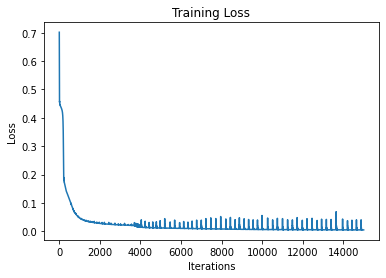

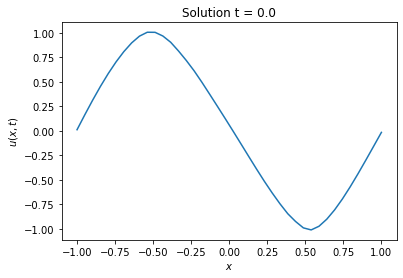

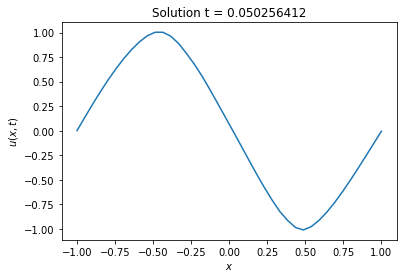

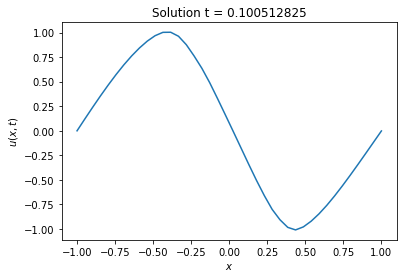

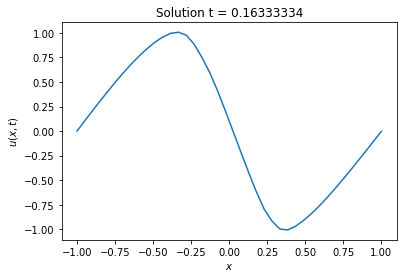

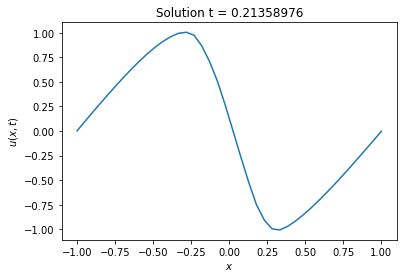

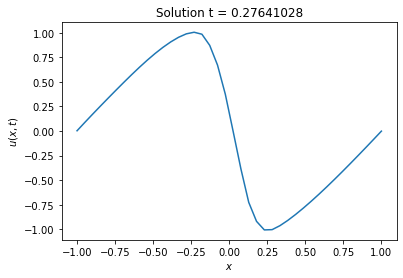

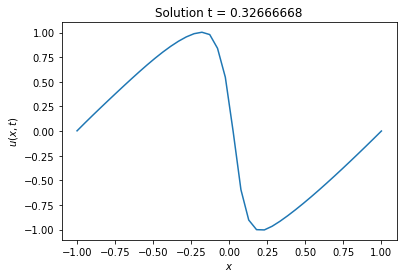

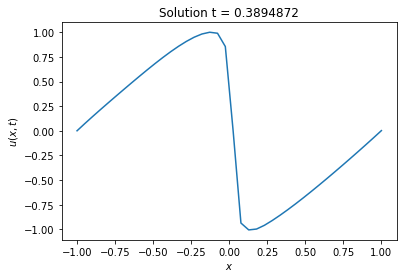

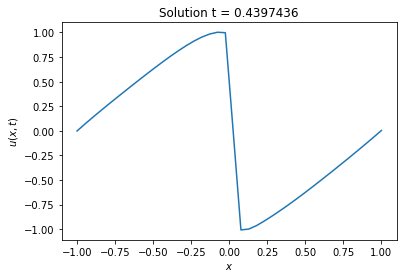

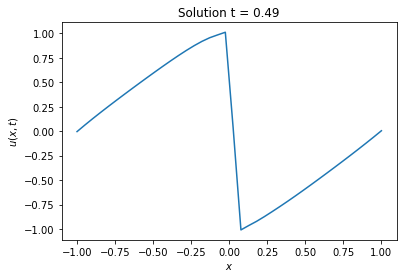

In [57]:
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

num_plot = 10

model.eval()
with torch.no_grad(): 
  out = model(xs.flatten().unsqueeze(1), ts.flatten().unsqueeze(1)).flatten().numpy()
out = out.reshape((num_x_points,num_t_points))


for i in range(num_plot):

  plt.plot(xs.numpy()[int(min(i*num_t_points/(num_plot-1), num_t_points-1))], out[int(min(i*num_t_points/(num_plot-1), num_t_points-1))])
  plt.title('Solution t = '+str(ts.numpy()[int(min(i*num_t_points/(num_plot-1), num_t_points-1))][0]))
  plt.xlabel(f'$x$')
  plt.ylabel(f'$u(x,t)$')
  plt.show()
